# MLIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Learning Objectives

1. Fit **MLIKH** to LAOS data (nonlinear oscillatory response)
2. Analyze **multi-mode Lissajous figures** and harmonic content
3. Compare nonlinearity from single vs multi-mode models
4. Understand mode interactions in large amplitude deformation

## Prerequisites

- NB06: MIKH LAOS (single-mode understanding)
- NB07: MLIKH Flow Curve (multi-mode basics)

## Runtime

- Fast demo: ~5-6 minutes
- Full run: ~20-25 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import rfft, rfftfreq

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_pnas_laos,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3


81

## 2. Theory: Multi-Mode LAOS

In MLIKH LAOS, each mode responds independently to the applied strain:

$$
\sigma_{total}(t) = \sum_{i=1}^N \sigma_i(t) + \eta_{\infty} \dot{\gamma}(t)
$$

### Mode Interactions

- Modes yield at different strains
- Different restructuring timescales within cycle
- Complex harmonic content from mode superposition

### Harmonic Enrichment

Multi-mode models can produce:
- Richer higher harmonic content ($I_5/I_1$, $I_7/I_1$)
- More complex Lissajous shapes
- Frequency-dependent nonlinearity

## 3. Load Data

In [3]:
# Load LAOS data
omega = 1.0
strain_amp_idx = 8

t_data, strain_data, stress_data = load_pnas_laos(
    omega=omega,
    strain_amplitude_index=strain_amp_idx
)

gamma_0 = np.max(np.abs(strain_data))
print(f"LAOS data: omega = {omega} rad/s, gamma_0 = {gamma_0:.4f}")
print(f"Points: {len(t_data)}")
# In FAST_MODE, subsample to 200 points to reduce ODE solve cost
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
if FAST_MODE and len(t_data) > 200:
    indices = np.linspace(0, len(t_data) - 1, 200, dtype=int)
    t_data = t_data[indices]
    strain_data = strain_data[indices]
    stress_data = stress_data[indices]
    print(f"  FAST_MODE: subsampled to {len(t_data)} points")


LAOS data: omega = 1.0 rad/s, gamma_0 = 3.1599
Points: 1000
  FAST_MODE: subsampled to 200 points


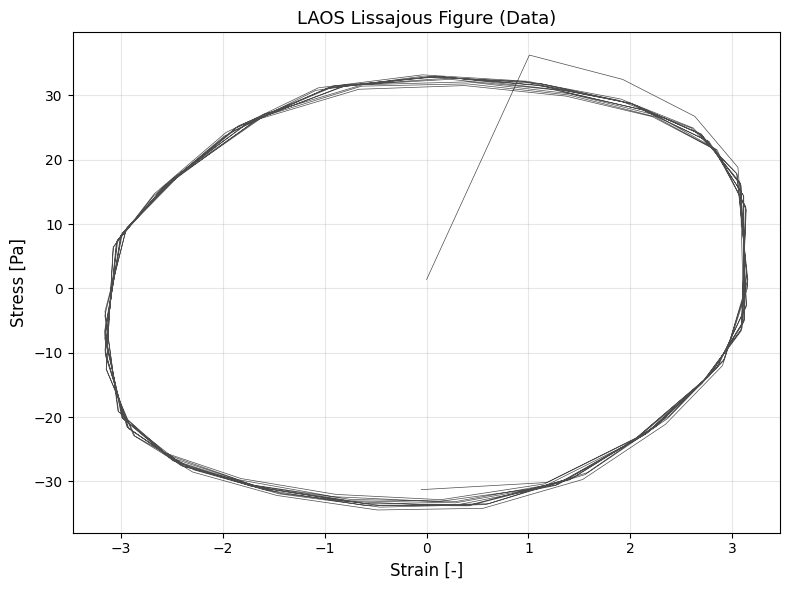

In [4]:
# Plot Lissajous
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(strain_data, stress_data, "k-", lw=0.5, alpha=0.7)
ax.set_xlabel("Strain [-]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("LAOS Lissajous Figure (Data)", fontsize=13)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit MLIKH model
n_modes = 2
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

print(f"Fitting MLIKH ({n_modes} modes) to LAOS")
t0 = time.time()
model.fit(t_data, stress_data, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")

Fitting MLIKH (2 modes) to LAOS


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/ml_ikh.py", line 623, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.71 s


In [6]:
# Compute fit quality
stress_pred = model.predict(t_data, test_mode="laos",  gamma_0=gamma_0,  omega=omega)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   -42.336538
  RMSE:  162.3 Pa


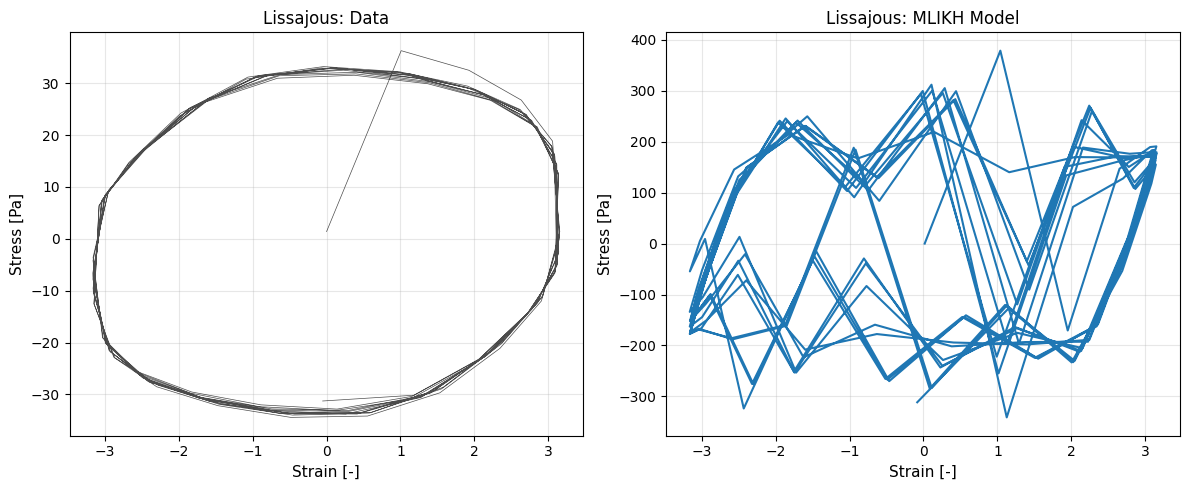

In [7]:
# Compare Lissajous figures
strain_pred = gamma_0 * np.sin(omega * np.array(t_data))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strain_data, stress_data, "k-", lw=0.5, alpha=0.7)
ax1.set_xlabel("Strain [-]", fontsize=11)
ax1.set_ylabel("Stress [Pa]", fontsize=11)
ax1.set_title("Lissajous: Data", fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.plot(strain_pred, stress_pred, "-", lw=1.5, color="C0")
ax2.set_xlabel("Strain [-]", fontsize=11)
ax2.set_ylabel("Stress [Pa]", fontsize=11)
ax2.set_title("Lissajous: MLIKH Model", fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Harmonic Analysis

In [8]:
# Extract harmonics
def extract_harmonics(t, y, omega, n_harmonics=5):
    n = len(y)
    dt = np.mean(np.diff(t))
    Y = rfft(y)
    freqs = rfftfreq(n, dt)
    f0 = omega / (2 * np.pi)
    idx_f0 = np.argmin(np.abs(freqs - f0))
    
    harmonics = {}
    for h in range(1, n_harmonics + 1):
        idx = idx_f0 * h
        if idx < len(Y):
            harmonics[h] = 2 * np.abs(Y[idx]) / n
        else:
            harmonics[h] = 0.0
    return harmonics

harmonics_data = extract_harmonics(t_data, stress_data, omega)
harmonics_model = extract_harmonics(t_data, np.array(stress_pred), omega)

print("Harmonic Analysis:")
print(f"{'Harmonic':<10} {'Data [Pa]':>12} {'Model [Pa]':>12}")
print("-" * 36)
for h in range(1, 6):
    print(f"  I_{h:<6}    {harmonics_data.get(h, 0):12.3f}   {harmonics_model.get(h, 0):12.3f}")

I3_I1_data = harmonics_data.get(3, 0) / harmonics_data.get(1, 1)
I3_I1_model = harmonics_model.get(3, 0) / harmonics_model.get(1, 1)
print(f"\nThird harmonic ratio I_3/I_1:")
print(f"  Data:  {I3_I1_data:.4f}")
print(f"  Model: {I3_I1_model:.4f}")

Harmonic Analysis:
Harmonic      Data [Pa]   Model [Pa]
------------------------------------
  I_1               24.963        127.996
  I_2                1.266         11.290
  I_3                0.242         17.214
  I_4                0.391          7.590
  I_5                0.395         10.688

Third harmonic ratio I_3/I_1:
  Data:  0.0097
  Model: 0.1345


## 6. Multi-Frequency Comparison

omega = 1.0 rad/s: 1000 points


omega = 3.0 rad/s: 1000 points


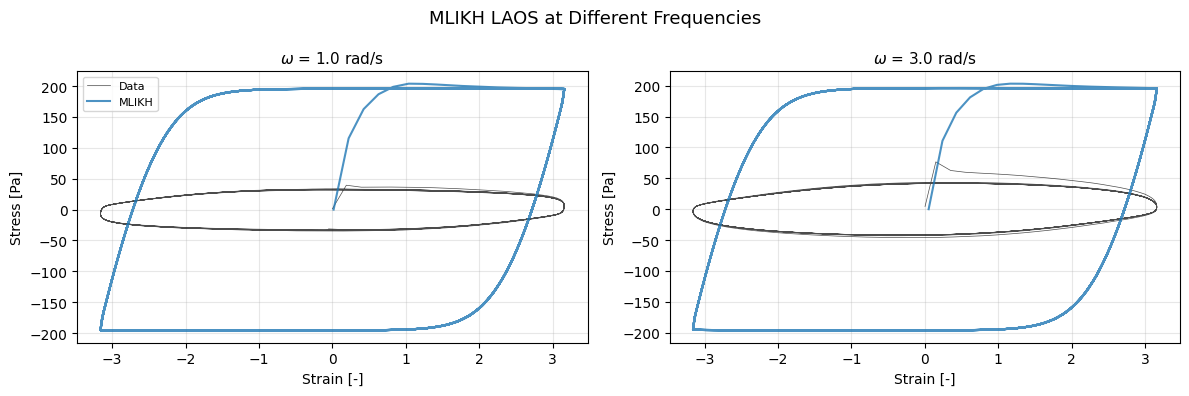

In [9]:
# Load and compare at multiple frequencies (with fallback for missing data)
omega_values = [1.0, 3.0]  # omega=5.0 may not have data at all strain amplitudes
laos_datasets = {}

for w in omega_values:
    try:
        t, strain, stress = load_pnas_laos(omega=w, strain_amplitude_index=strain_amp_idx)
        if len(t) > 0 and len(strain) > 0:
            laos_datasets[w] = {"time": t, "strain": strain, "stress": stress}
            print(f"omega = {w} rad/s: {len(t)} points")
    except Exception as e:
        print(f"omega = {w} rad/s: Failed to load")

n_datasets = len(laos_datasets)
if n_datasets > 0:
    fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 4))
    if n_datasets == 1:
        axes = [axes]

    for i, w in enumerate(laos_datasets.keys()):
        d = laos_datasets[w]
        gamma_0_w = np.max(np.abs(d["strain"]))
        
        # Model prediction
        stress_pred_w = model.predict(d["time"], test_mode="laos", gamma_0=gamma_0_w, omega=w)
        strain_pred_w = gamma_0_w * np.sin(w * np.array(d["time"]))
        
        axes[i].plot(d["strain"], d["stress"], "k-", lw=0.5, alpha=0.7, label="Data")
        axes[i].plot(strain_pred_w, stress_pred_w, "-", lw=1.5, color="C0", alpha=0.8, label="MLIKH")
        axes[i].set_xlabel("Strain [-]", fontsize=10)
        axes[i].set_ylabel("Stress [Pa]", fontsize=10)
        axes[i].set_title(f"$\\omega$ = {w} rad/s", fontsize=11)
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend(fontsize=8)

    plt.suptitle("MLIKH LAOS at Different Frequencies", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("No LAOS datasets available for multi-frequency comparison")

## 7. Bayesian Inference

In [10]:
# Clear JAX compilation caches and garbage before Bayesian inference
# to reduce peak memory for ODE-based LAOS NUTS sampling
import gc
gc.collect()
try:
    jax.clear_caches()
except Exception:
    pass

# Bayesian inference (reduced for time-domain LAOS)
initial_values = {name: model.parameters.get_value(name) for name in param_names}

# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 25
    NUM_SAMPLES = 50
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print("(Note: Time-domain LAOS inference is slow, using reduced samples)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="laos",
    gamma_0=gamma_0,
    omega=omega,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 25 warmup + 50 samples x 1 chain(s)
(Note: Time-domain LAOS inference is slow, using reduced samples)


  0%|          | 0/75 [00:00<?, ?it/s]

warmup:   1%|▏         | 1/75 [00:00<00:38,  1.91it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  31%|███       | 23/75 [00:00<00:01, 45.83it/s, 127 steps of size 2.70e-05. acc. prob=0.71]

sample:  60%|██████    | 45/75 [00:00<00:00, 72.08it/s, 255 steps of size 3.84e-04. acc. prob=1.00]

sample:  84%|████████▍ | 63/75 [00:00<00:00, 94.76it/s, 7 steps of size 3.84e-04. acc. prob=1.00]  

sample: 100%|██████████| 75/75 [00:01<00:00, 74.56it/s, 15 steps of size 3.84e-04. acc. prob=1.00]


Bayesian inference time: 3.7 s


In [11]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    1.9777         3     CHECK
            C_1    2.0787         3     CHECK
    gamma_dyn_1    2.0797         3     CHECK
     sigma_y0_1    2.2295         3     CHECK
delta_sigma_y_1    1.0258         9     CHECK
     tau_thix_1    1.3810         5     CHECK
        Gamma_1    2.3429         3     CHECK
            G_2    2.0757         3     CHECK
            C_2    2.0835         3     CHECK
    gamma_dyn_2    1.6118         5     CHECK
     sigma_y0_2    1.7874         3     CHECK
delta_sigma_y_2    1.6705         4     CHECK
     tau_thix_2    1.6405         4     CHECK
        Gamma_2    2.3073         3     CHECK
        eta_inf    1.2205         5     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


## 8. Physical Interpretation

### Multi-Mode Nonlinearity

- **Mode superposition**: Each mode contributes to nonlinear response
- **Different timescales**: Modes restructure at different rates within cycle
- **Harmonic enrichment**: Multiple modes can create richer higher harmonics

### Frequency Dependence

- **Low frequency**: All modes have time to restructure
- **High frequency**: Structure frozen, pure elastoplastic response

## 9. Save Results

In [12]:
# Save results
save_ikh_results(model, result, "mlikh", "laos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/laos/
  nlsq_params_laos.json: 15 parameters
  posterior_laos.json: 50 draws


## Key Takeaways

1. **MLIKH LAOS** captures multi-mode nonlinear oscillatory response

2. **Harmonic analysis** reveals mode contributions to nonlinearity

3. **Mode interactions** create complex Lissajous shapes

4. **Frequency dependence** arises from distributed thixotropic timescales

5. Multi-mode models can capture richer nonlinear features than single-mode

### Summary: IKH Tutorial Suite

This completes the 12-notebook IKH tutorial suite:

**MIKH (Single-Mode):**
- NB01: Flow Curve
- NB02: Startup Shear
- NB03: Stress Relaxation (synthetic)
- NB04: Creep
- NB05: SAOS (synthetic)
- NB06: LAOS

**MLIKH (Multi-Mode):**
- NB07: Flow Curve
- NB08: Startup Shear
- NB09: Stress Relaxation (synthetic)
- NB10: Creep
- NB11: SAOS (synthetic)
- NB12: LAOS

In [13]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
